# SVM 분류 기본 코드

## #01. 준비작업

### [1] 패키지 가져오기

sklearn에서는 `Support Vector Machine Classification`을 줄여서 `SVC`로 명명하고 있다.

sklearn에서 지원하는 `SVM` 알고리즘은 선형 분류만을 지원하는 `LinearSVC`와 선형 분류와 비선형 분류를 모두 지원하는 `SVC` 클래스가 있다.

In [12]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

from sklearn.tree import export_graphviz
from sklearn.svm import LinearSVC, SVC

In [13]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [14]:
# CPU 가속만
from sklearnex import patch_sklearn, config_context
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [15]:
# from sklearn.cluster import DBSCAN

# with config_context(target_offload="gpu:0"):
#     clustering = DBSCAN(eps=3, min_samples=2).fit(X)

### [2] 데이터 가져오기

In [16]:
origin = my_read_excel("https://data.hossam.kr/mldata/dogs.xlsx", categories=['dog'], info=False)

## #02. 데이터 전처리

1. 종속변수 라벨링 및 형변환
2. 훈련/검증 데이터 분리

In [17]:
df = my_labelling(origin, 'dog')
x_train, x_test, y_train, y_test = my_train_test_split(df, yname='dog')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((160, 2), (40, 2), (160,), (40,))

## #02. LinearSVC (Linear Support Vector Machine Classification)

### [1] 분류 모델 구현

| 하이퍼파라미터 | 기능 | 기본값 | 추천값과 설명 |
|---|---|---|---|
| `penalty` | 모델의 과적합을 방지하기 위해 사용되는 정규화 유형을 지정한다. | `l2` | -`l1`: 몇몇 가중치를 0으로 만들어 특성 선택 효과를 낼 수 있음<br/>-`l2`: 가중치의 제곱 합에 비례하는 비용을 추가함. |
| `loss` | 모델이 학습하는 동안 최소화될 손실 함수를 지정한다.| `squared_hinge` | -`hinge`: 마진 오류를 직접 최적화하며, SVM의 표준 손실 함수<br/>-`squared_hinge`: 힌지 손실의 제곱으로, 이상치에 덜 민감하나 최적화가 더 쉬움. |
| `C` | 정규화의 강도를 반대로 제어한다. 값이 작을수록 모델은 더 강하게 정규화된다.| `1.0` | -`0.01`: 매우 강한 정규화, 과적합을 막고자 할 때 사용<br/>-`1.0`: 중간 정도의 정규화, 기본값으로 대부분의 경우 잘 작동. `10.0`: 약한 정규화, 과소적합 문제를 해결하고자 할 때 사용. |
| `max_iter` | 최적화 알고리즘에 의해 수행될 최대 반복 횟수를 지정한다.| `1000` | -`100`: 빠른 프로토타이핑이나 작은 데이터셋에 적합<br/>-`1000`: 기본 설정으로 대부분의 경우에 적합<br/>-`10000`: 매우 복잡하거나 대규모 데이터셋에서 성능을 개선하기 위해 사용. |
| `dual` | 최적화 문제의 이중 형식 또는 원시 형식을 선택한다. `n_samples > n_features`인 경우 `False`가 권장된다. | `True`| -`True`: 특성의 수가 샘플의 수보다 많을 때 권장<br/>-`False`: 샘플의 수가 특성의 수보다 많을 때 권장, 계산 효율성을 높일 수 있음. |
| `random_state` | 랜덤시드를 고정한다. | 없음 | 임의의 숫자 |

In [18]:
estimator = LinearSVC(
    penalty='l2',
    C=1,
    loss='hinge',
    max_iter=1000,
    dual=True,
    random_state=0
    
)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

훈련데이터 점수:  1.0
검증데이터 점수:  1.0


### [2] 성능평가

분류 확률을 얻을 수 없기 때문에 `predict_proba()` 메서드가 제공되지 않는다.

그러므로 `roc_curve` 시각화가 불가능하며 `auc`값을 얻을 수 없다

## 03. SVC 

### [1] 분류 모델 구현

| 하이퍼파라미터 | 기능 | 기본값 | 추천값과 설명 |
|---|---|---|---|
| `C` | 오류 항에 대한 페널티를 결정한다. 값이 클수록 오류에 대한 페널티가 커진다. | `1.0` | -`0.1`: 더 강한 정규화를 원할 때 사용<br/>-`1.0`: 기본값, 균형 잡힌 정규화.<br/>-`10`: 오류에 더 유연하게 대응하고자 할 때 사용. |
| `kernel` | 변환의 종류를 결정한다. 데이터를 더 높은 차원으로 매핑하는 함수. | `rbf` | -`linear`: 선형 분류 문제.<br/>-`poly`: 다항식 커널, 복잡한 데이터셋에 적합<br/>-`rbf`: 기본값, 비선형 문제에 좋음<br/>-`sigmoid`: 신경망과 유사한 효과. |
| `degree` | `kernel='poly'`일 때 다항식의 차수를 결정한다. 높은 차수는 더 복잡한 결정 경계를 만든다. | `3` | -`3`: 기본값, 대부분의 경우에 적합<br/> -`2`, `4`, `5`: 데이터의 특성과 복잡성에 따라 조정.                                    |
| `gamma` | `kernel='rbf'`, `poly` 및 `sigmoid`에 대한 커널 계수를 결정한다. 값이 클수록 결정 경계가 더 복잡해진다. | `scale` | -`auto`: 특성 수의 역수로 설정<br/>-`scale`: `1 / (n_features * X.var())`로 설정, 데이터의 스케일에 따라 조정.                 |
| `coef0` | `kernel='poly'`와 `sigmoid`에서 독립 항을 결정한다. 커널 함수의 독립적인 항을 조절한다. | `0` | -`0`: 기본값, 대부분의 경우에 적합<br/>-`0.01`, `10`, `-10`: 커널 함수에 따라 실험적으로 조정할 수 있음.                      |
| `shrinking` | 최적화를 위한 축소 휴리스틱을 사용할지 여부를 결정한다. | `True`| -`True`: 기본값, 대부분의 경우에 적합<br/>-`False`: 축소 휴리스틱을 사용하지 않을 경우. |
| `probability` | 클래스 멤버십 확률을 추정할지 여부를 결정한다. 확률 추정은 내부적으로 5-겹 교차 검증을 사용한다.  | `False` | -`False`: 기본값, 빠른 계산을 위해<br/>-`True`: 클래스 확률을 필요로 할 때 사용, 계산에 더 많은 시간이 필요함.                      |
| `max_iter` | 솔버 내부 반복의 최대 횟수를 결정한다. `-1`은 무제한을 의미한다. | `-1`  | -`-1`: 기본값, 반복에 제한 없음<br/>-`1000`<br/>-`10000`: 특정 반복 횟수 내에서 수렴하도록 제한하고 싶을 때 사용.                     |


### [2] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |            1 |            1 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |            1 |            1 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |            1 |            1 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |            0 |            0 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |            1 |            1 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |            1 |            1 | 정밀도와 재현율의 조화평균                                |
+-------------------+--------------+--------------+-------------------------------------------------

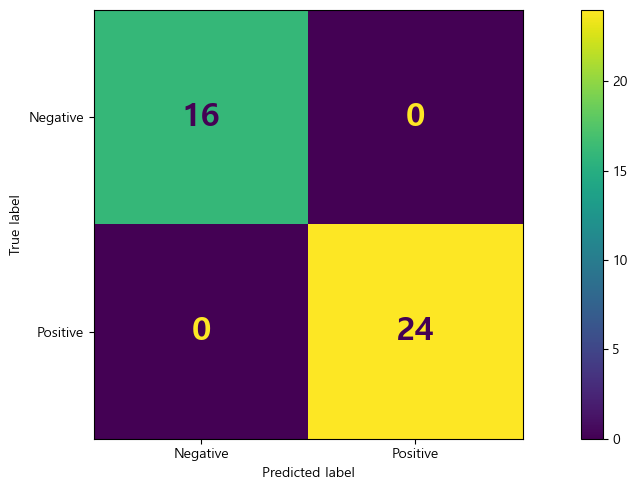


[학습곡선]


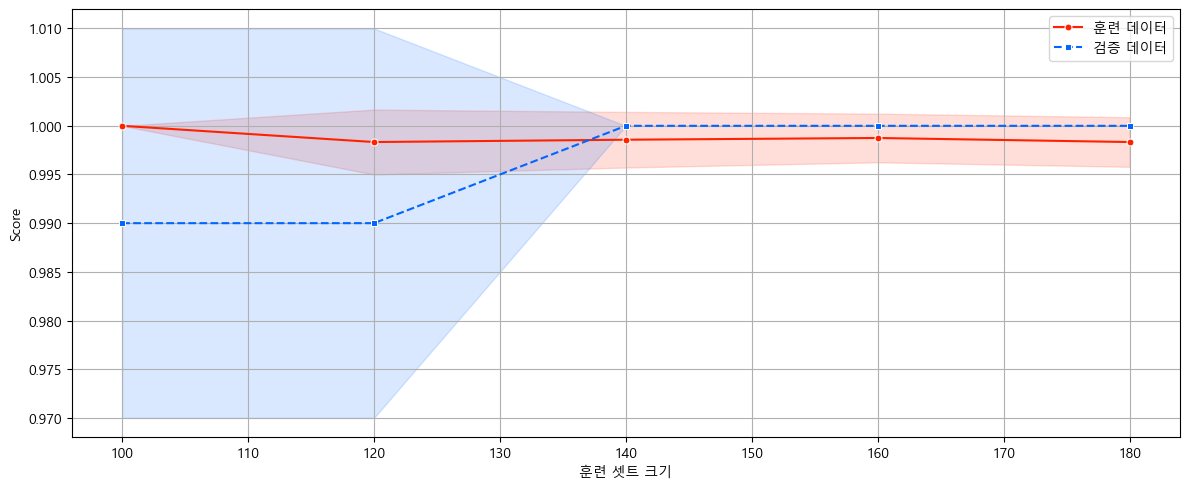

In [19]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

## 03. SVC 

### [1] 분류 모델 구현

| 하이퍼파라미터 | 기능 | 기본값 | 추천값과 설명 |
|---|---|---|---|
| `C` | 오류 항에 대한 페널티를 결정한다. 값이 클수록 오류에 대한 페널티가 커진다. | `1.0` | -`0.1`: 더 강한 정규화를 원할 때 사용<br/>-`1.0`: 기본값, 균형 잡힌 정규화.<br/>-`10`: 오류에 더 유연하게 대응하고자 할 때 사용. |
| `kernel` | 변환의 종류를 결정한다. 데이터를 더 높은 차원으로 매핑하는 함수. | `rbf` | -`linear`: 선형 분류 문제.<br/>-`poly`: 다항식 커널, 복잡한 데이터셋에 적합<br/>-`rbf`: 기본값, 비선형 문제에 좋음<br/>-`sigmoid`: 신경망과 유사한 효과. |
| `degree` | `kernel='poly'`일 때 다항식의 차수를 결정한다. 높은 차수는 더 복잡한 결정 경계를 만든다. | `3` | -`3`: 기본값, 대부분의 경우에 적합<br/> -`2`, `4`, `5`: 데이터의 특성과 복잡성에 따라 조정.                                    |
| `gamma` | `kernel='rbf'`, `poly` 및 `sigmoid`에 대한 커널 계수를 결정한다. 값이 클수록 결정 경계가 더 복잡해진다. | `scale` | -`auto`: 특성 수의 역수로 설정<br/>-`scale`: `1 / (n_features * X.var())`로 설정, 데이터의 스케일에 따라 조정.                 |
| `coef0` | `kernel='poly'`와 `sigmoid`에서 독립 항을 결정한다. 커널 함수의 독립적인 항을 조절한다. | `0` | -`0`: 기본값, 대부분의 경우에 적합<br/>-`0.01`, `10`, `-10`: 커널 함수에 따라 실험적으로 조정할 수 있음.                      |
| `shrinking` | 최적화를 위한 축소 휴리스틱을 사용할지 여부를 결정한다. | `True`| -`True`: 기본값, 대부분의 경우에 적합<br/>-`False`: 축소 휴리스틱을 사용하지 않을 경우. |
| `probability` | 클래스 멤버십 확률을 추정할지 여부를 결정한다. 확률 추정은 내부적으로 5-겹 교차 검증을 사용한다.  | `False` | -`False`: 기본값, 빠른 계산을 위해<br/>-`True`: 클래스 확률을 필요로 할 때 사용, 계산에 더 많은 시간이 필요함.                      |
| `max_iter` | 솔버 내부 반복의 최대 횟수를 결정한다. `-1`은 무제한을 의미한다. | `-1`  | -`-1`: 기본값, 반복에 제한 없음<br/>-`1000`<br/>-`10000`: 특정 반복 횟수 내에서 수렴하도록 제한하고 싶을 때 사용.                     |


In [20]:
estimator =  SVC(
    C=1.0,
    kernel = 'rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=True,
    max_iter=-1)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

훈련데이터 점수:  1.0
검증데이터 점수:  1.0


### [2] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |            1 |            1 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |            1 |            1 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |            1 |            1 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |            0 |            0 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |            1 |            1 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |            1 |            1 | 정밀도와 재현율의 조화평균                                |
| AUC               |            1 |            1 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

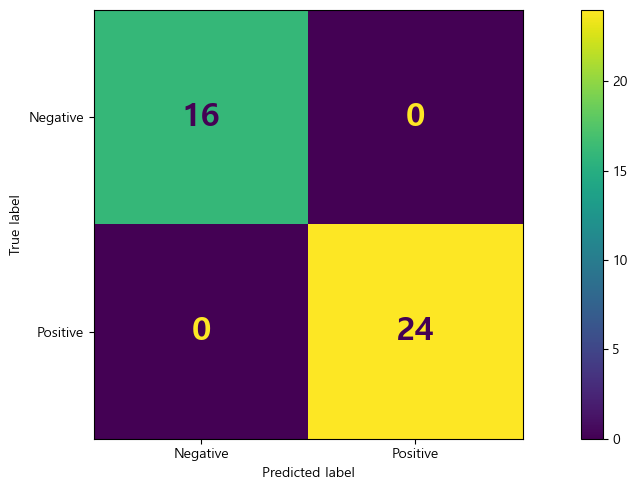

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


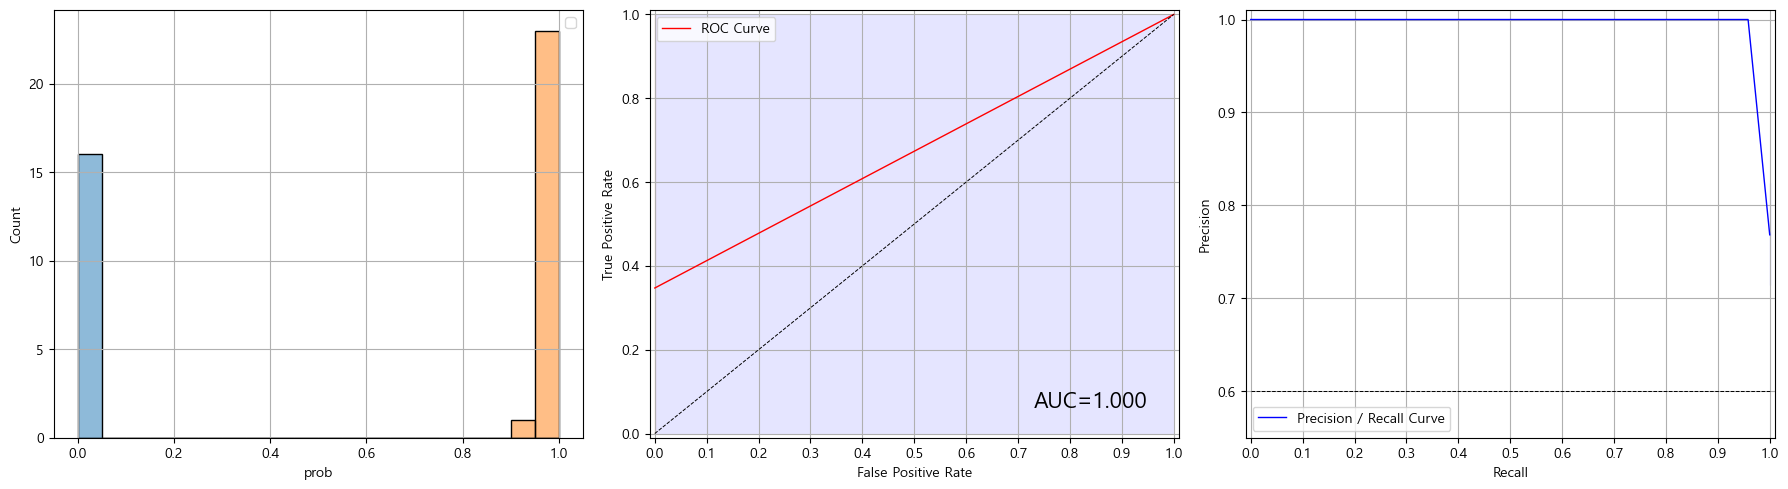


[학습곡선]


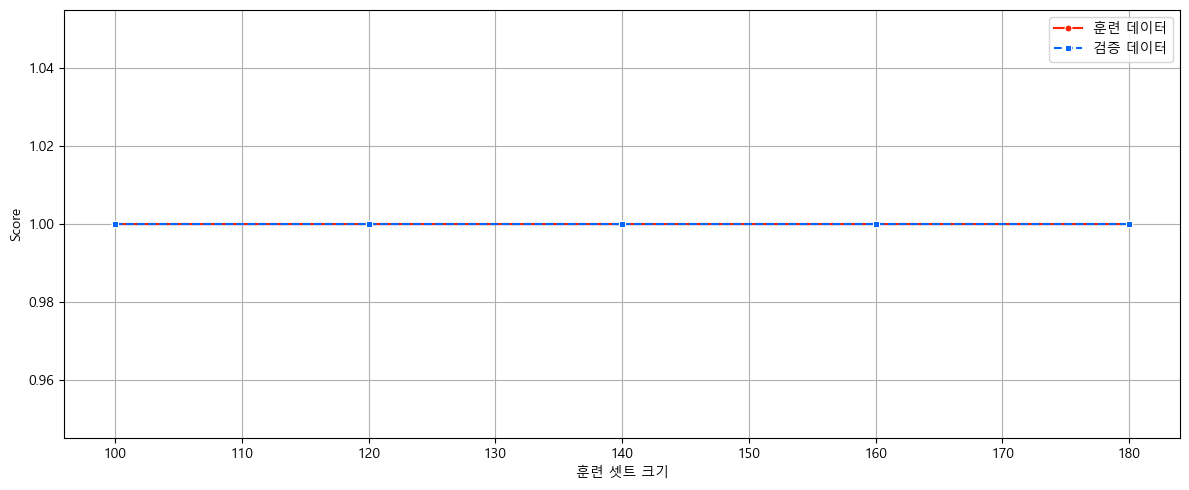

In [21]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

### [3] 모듈화 기능 확인

<class 'sklearn.svm._classes.LinearSVC'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+----------------+-----------+------------+---------------+--------+------+-------------------+
|    |   random_state | penalty   |   max_iter | loss          | dual   |    C |   mean_test_score |
|----+----------------+-----------+------------+---------------+--------+------+-------------------|
|  1 |           1234 | l2        |       1000 | squared_hinge | True   | 0.01 |                 1 |
|  4 |           1234 | l1        |       1000 | squared_hinge | False  | 0.01 |                 1 |
|  5 |           1234 | l2        |       1000 | squared_hinge | False  | 0.01 |                 1 |
|  9 |           1234 | l2        |       1000 | squared_hinge | True   |  0.1 |                 1 |
| 11 |           1234 | l2        |       1000 | hinge         | True   |  0.1 |                 1 |
+----+----------------+-----------+------------+---------------+--------+------+-------------------+

[분류분석 성능평가]
+-------

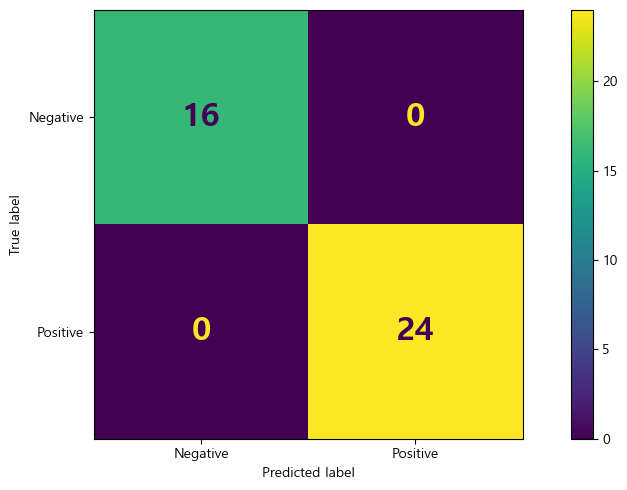


[학습곡선]


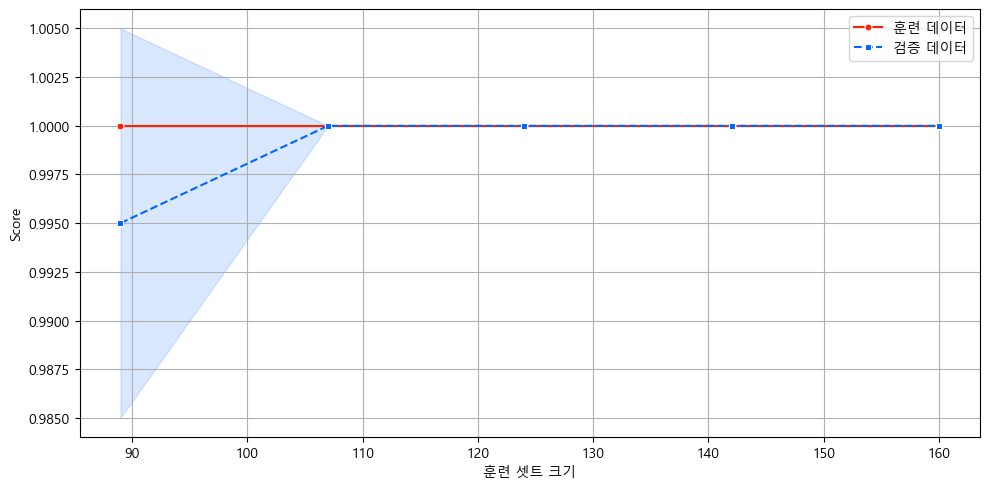

LinearSVC(C=0.01, dual=True, random_state=1234)

In [22]:
my_linear_svc_classification(x_train,y_train, x_test, y_test)

<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+----------+----------+-----+-------------------+
|    | kernel   |   degree |   C |   mean_test_score |
|----+----------+----------+-----+-------------------|
|  0 | rbf      |        2 | 0.1 |                 1 |
| 15 | rbf      |        3 |   1 |                 1 |
| 34 | poly     |        5 |  10 |                 1 |
| 33 | rbf      |        5 |  10 |                 1 |
| 31 | poly     |        4 |  10 |                 1 |
+----+----------+----------+-----+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |            1 |            1 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Preci

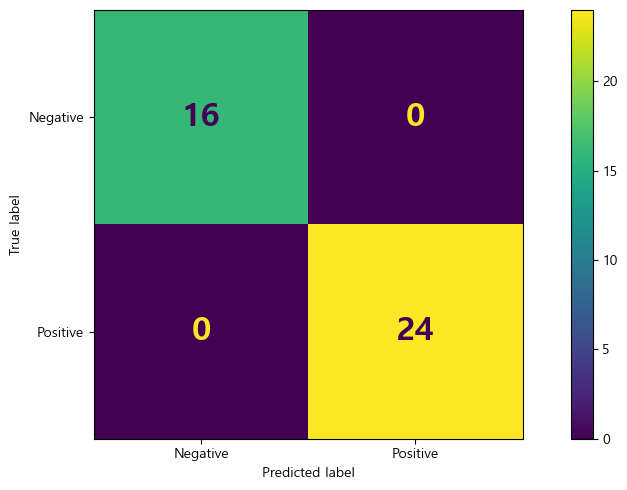


[학습곡선]


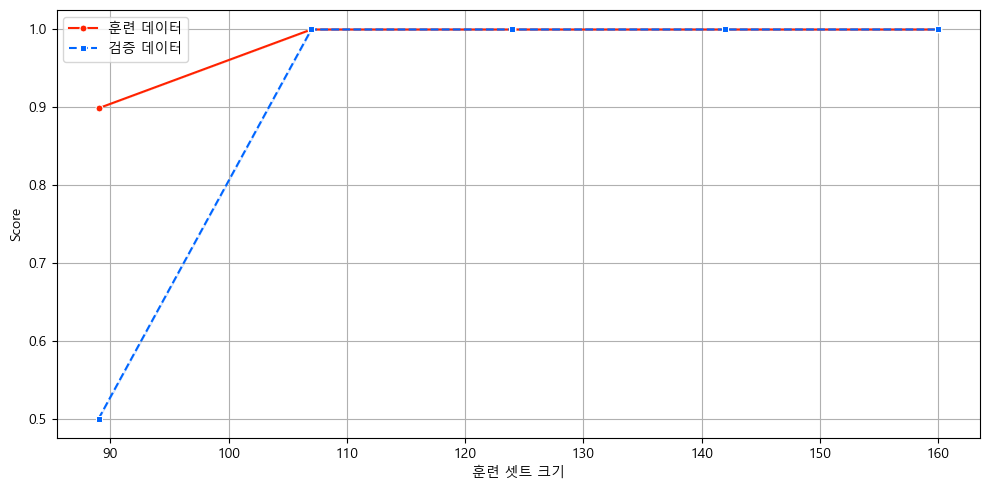

SVC(C=0.1, degree=2)

In [23]:
my_svc_classification(x_train, y_train, x_test, y_test)

### [4] 모든 모형에 대한 성능 비교 모듈 

In [24]:
my_classification(x_train,y_train,x_test,y_test)

<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+-------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |   AUC |
|------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+-------|
| GaussianNB             |                         0 |                  1 |                   1 |                1 |                   0 |             1 |          1 |     1 |
| DecisionTreeClassifier |                         0 |                  1 |                   1 |                1 |                   0

{'GaussianNB': GaussianNB(),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'LogisticRegression': LogisticRegression(C=0.001, max_iter=1000, n_jobs=-1),
 'SVC': SVC(C=0.1, degree=2),
 'KNeighborsClassifier': KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3)}

## 인디언 당뇨병 데이터

In [25]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB
None

데이터프레임 상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   

In [26]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']                

In [27]:
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.00000,155.548223,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.00000,155.548223,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,29.15342,155.548223,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1.0


In [28]:
total_count= len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))
    
print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


In [29]:
df2 = my_labelling(df2, 'Outcome')
x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Outcome')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [30]:
estimator = LinearSVC(
    penalty='l2',
    C=1,
    loss='hinge',
    max_iter=1000,
    dual=True,
    random_state=0
    
)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

훈련데이터 점수:  0.7198697068403909
검증데이터 점수:  0.7402597402597403


<class 'sklearn.svm._classes.LinearSVC'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+----------------+-----------+------------+---------------+--------+-----+-------------------+
|    |   random_state | penalty   |   max_iter | loss          | dual   |   C |   mean_test_score |
|----+----------------+-----------+------------+---------------+--------+-----+-------------------|
| 21 |           1234 | l2        |       1000 | squared_hinge | False  |   1 |          0.765534 |
| 12 |           1234 | l1        |       1000 | squared_hinge | False  | 0.1 |          0.763948 |
| 20 |           1234 | l1        |       1000 | squared_hinge | False  |   1 |          0.762282 |
| 28 |           1234 | l1        |       1000 | squared_hinge | False  |  10 |          0.762282 |
| 29 |           1234 | l2        |       1000 | squared_hinge | False  |  10 |          0.762282 |
+----+----------------+-----------+------------+---------------+--------+-----+-------------------+

[분류분석 성능평가]
+----------------

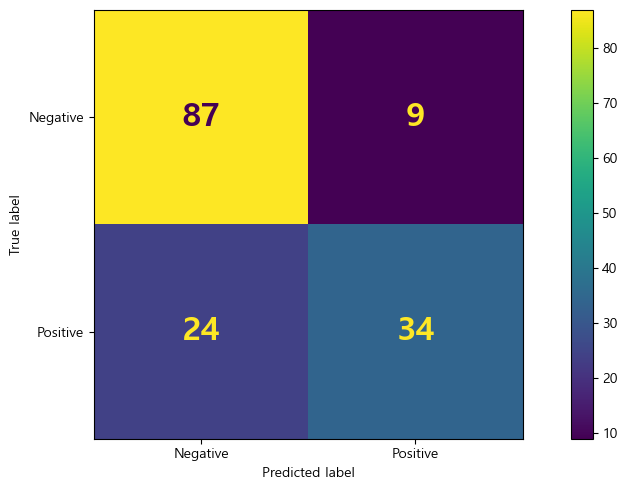


[학습곡선]


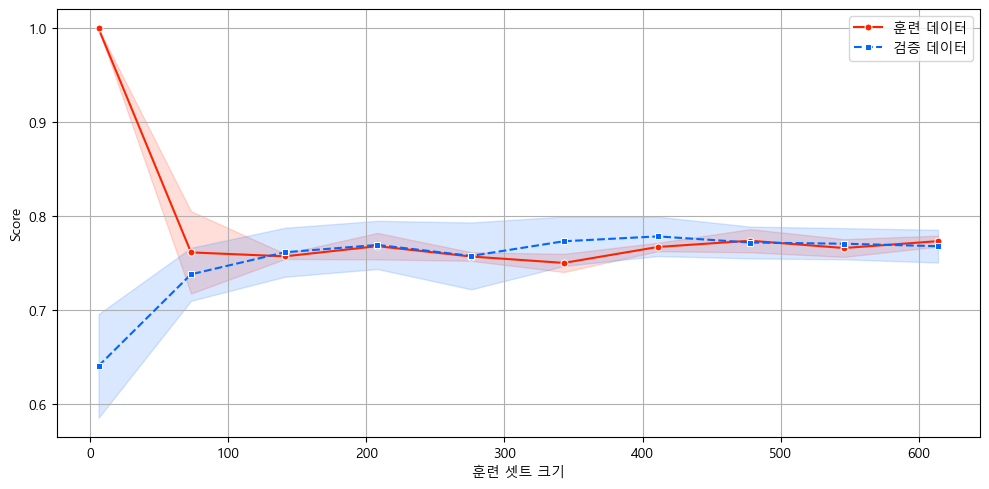

LinearSVC(C=1, dual=False, random_state=1234)

In [31]:
my_linear_svc_classification(x_train,y_train, x_test, y_test)

In [32]:
estimator =  SVC(
    C=1.0,
    kernel = 'rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=True,
    max_iter=-1)

estimator.fit(x_train, y_train)
print("훈련데이터 점수: ", estimator.score(x_train, y_train))
print("검증데이터 점수: ", estimator.score(x_test, y_test))

훈련데이터 점수:  0.760586319218241
검증데이터 점수:  0.7857142857142857


<class 'sklearn.svm._classes.SVC'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+----------+----------+-----+-------------------+
|    | kernel   |   degree |   C |   mean_test_score |
|----+----------+----------+-----+-------------------|
| 25 | poly     |        2 |  10 |          0.770412 |
| 13 | poly     |        2 |   1 |          0.763894 |
| 27 | rbf      |        3 |  10 |          0.759003 |
| 33 | rbf      |        5 |  10 |          0.759003 |
| 24 | rbf      |        2 |  10 |          0.759003 |
+----+----------+----------+-----+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.778502 |     0.772727 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Preci

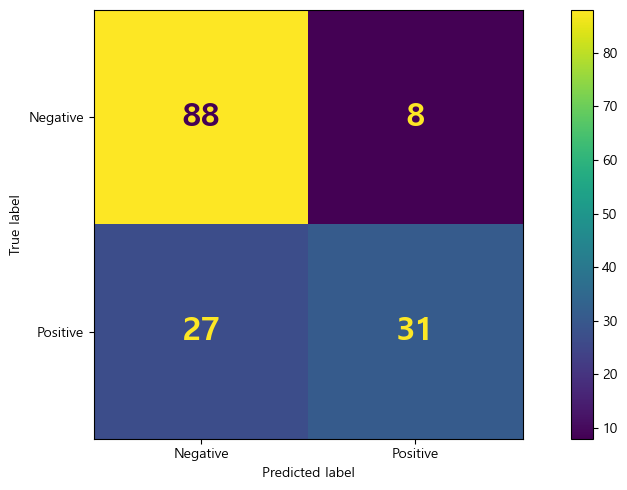


[학습곡선]


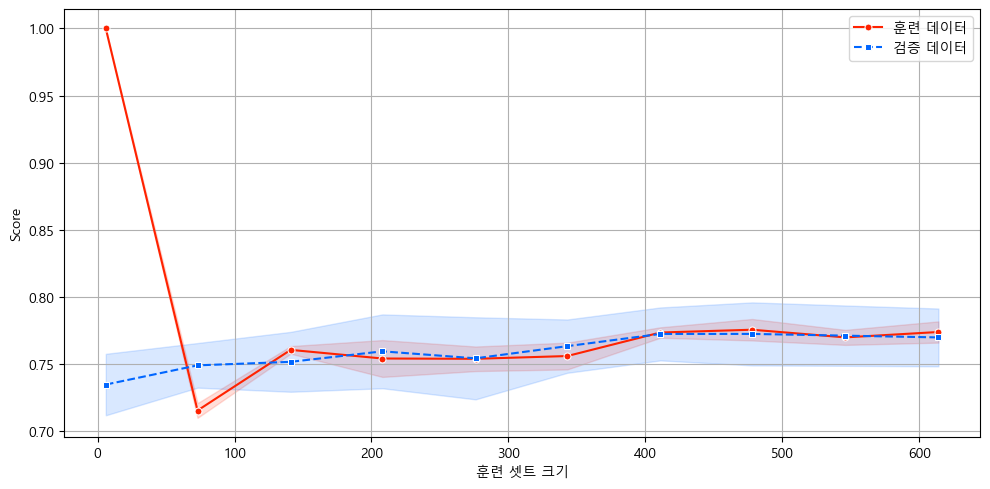

SVC(C=10, degree=2, kernel='poly')

In [33]:
my_svc_classification(x_train, y_train, x_test, y_test)